In [4]:
!pip install -q transformers datasets evaluate scikit-learn nltk matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import nltk
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

## Check Versions

In [6]:
# Check versions and install dependencies
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

PyTorch version: 2.6.0+cu124
Transformers version: 4.50.3


### Download NLTK resources

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Set device and perform context analysis

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ContextAnalyzer:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.conversation_history = []
        self.context_embeddings = []

    def add_message(self, message, speaker="user"):
        """Add a new message to the conversation history"""
        self.conversation_history.append({"text": message, "speaker": speaker, "timestamp": pd.Timestamp.now()})

    def get_conversation_history(self):
        """Return the full conversation history"""
        return self.conversation_history

    def extract_key_topics(self, text, top_n=5):
        """Extract key topics from text using simple keyword extraction"""
        tokens = word_tokenize(text.lower())
        # Remove stopwords
        stopwords = set(nltk.corpus.stopwords.words('english'))
        tokens = [token for token in tokens if token.isalpha() and token not in stopwords]

        # Count word frequencies
        word_freq = Counter(tokens)
        return word_freq.most_common(top_n)

    def get_embedding(self, text):
        """Get embedding for a text using the model"""
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use mean pooling to get sentence embedding
        token_embeddings = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"]

        # Mask padded tokens
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        # Sum the masked embeddings
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        # Sum the mask
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        # Get the mean embedding
        embedding = sum_embeddings / sum_mask

        return embedding.cpu().numpy()[0]

    def update_context_embedding(self):
        """Update the context embedding based on recent conversation history"""
        if not self.conversation_history:
            return np.zeros(384)  # Default embedding size for the model

        # Combine the last few messages
        recent_messages = [msg["text"] for msg in self.conversation_history[-5:]]
        combined_text = " ".join(recent_messages)

        # Get embedding for the combined text
        embedding = self.get_embedding(combined_text)
        self.context_embeddings.append(embedding)

        return embedding

    def detect_topic_drift(self, threshold=0.7):
        """Detect if the topic has drifted significantly"""
        if len(self.context_embeddings) < 2:
            return False

        # Compare the latest embedding with the previous one
        latest = self.context_embeddings[-1]
        previous = self.context_embeddings[-2]

        # Compute cosine similarity
        similarity = np.dot(latest, previous) / (np.linalg.norm(latest) * np.linalg.norm(previous))

        return similarity < threshold  # Return True if drift detected

    def summarize_context(self):
        """Summarize the current conversation context"""
        if not self.conversation_history:
            return "No conversation history yet."

        recent_messages = self.conversation_history[-5:]
        topics = []

        # Extract topics from recent messages
        for msg in recent_messages:
            msg_topics = self.extract_key_topics(msg["text"], top_n=3)
            topics.extend([topic for topic, _ in msg_topics])

        # Get the most common topics
        common_topics = Counter(topics).most_common(5)

        return {
            "message_count": len(self.conversation_history),
            "recent_speakers": [msg["speaker"] for msg in recent_messages],
            "key_topics": [topic for topic, _ in common_topics],
            "topic_drift_detected": self.detect_topic_drift() if len(self.context_embeddings) > 1 else False
        }

Using device: cpu


### 2. Tone Detection

In [12]:
class ToneDetector:
    def __init__(self):
        # Load pre-trained models for different aspects of tone
        print("Loading sentiment analysis model...")
        self.sentiment_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

        print("Loading emotion detection model...")
        # For emotion, we would typically use a model fine-tuned on emotion data
        # Here we'll use a placeholder and describe the process
        self.emotion_labels = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

        # For formality, we'd normally use a specialized model or rule-based system
        # Placeholder for demonstration
        self.formal_words = set(["therefore", "however", "consequently", "furthermore", "moreover"])
        self.informal_words = set(["gonna", "wanna", "lol", "btw", "idk", "tbh"])

    def detect_sentiment(self, text):
        """Detect sentiment (positive/negative) in text"""
        inputs = self.sentiment_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = self.sentiment_model(**inputs)

        # Get predicted class (0 = negative, 1 = positive)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
        score = torch.softmax(outputs.logits, dim=1)[0][predicted_class].item()

        return {
            "sentiment": "positive" if predicted_class == 1 else "negative",
            "confidence": score
        }

    def detect_emotion(self, text):
        """Detect dominant emotion in text"""
        # In a real implementation, you would:
        # 1. Use a model fine-tuned for emotion detection
        # 2. Process the text through the model
        # 3. Return the predicted emotion and confidence

        # Placeholder implementation using keyword matching
        text = text.lower()
        emotion_scores = {
            "joy": text.count("happy") + text.count("glad") + text.count("great"),
            "sadness": text.count("sad") + text.count("upset") + text.count("sorry"),
            "anger": text.count("angry") + text.count("mad") + text.count("frustrated"),
            "fear": text.count("afraid") + text.count("scared") + text.count("worried"),
            "surprise": text.count("wow") + text.count("amazing") + text.count("unexpected"),
            "disgust": text.count("gross") + text.count("disgusting") + text.count("awful")
        }

        # Get the emotion with the highest score
        dominant_emotion = max(emotion_scores, key=emotion_scores.get)
        total = sum(emotion_scores.values())
        confidence = emotion_scores[dominant_emotion] / total if total > 0 else 0

        return {
            "emotion": dominant_emotion,
            "confidence": confidence if total > 0 else 0.1,
            "all_emotions": emotion_scores
        }

    def assess_formality(self, text):
        """Assess the formality level of text"""
        words = set(word.lower() for word in word_tokenize(text) if word.isalpha())

        # Count formal and informal markers
        formal_markers = words.intersection(self.formal_words)
        informal_markers = words.intersection(self.informal_words)

        # Look for informal contractions
        contractions = text.count("'")

        # Check for exclamation marks, ellipses, etc.
        exclamations = text.count("!")
        ellipses = text.count("...")

        # Calculate a formality score (higher = more formal)
        formal_score = len(formal_markers) - len(informal_markers) - 0.5 * contractions - 0.5 * exclamations - 0.5 * ellipses

        # Normalize to 0-1 range
        formality = max(0, min(1, (formal_score + 5) / 10))

        return {
            "formality": formality,
            "formality_level": "high" if formality > 0.7 else "medium" if formality > 0.3 else "low"
        }

    def detect_urgency(self, text):
        """Detect the urgency level in text"""
        # Check for urgency markers
        urgency_phrases = ["asap", "urgent", "immediately", "as soon as possible", "emergency", "now", "right away"]

        # Count how many urgency markers are present
        urgency_count = sum(1 for phrase in urgency_phrases if phrase in text.lower())

        # Check for question marks and exclamation points
        question_marks = text.count("?")
        exclamation_points = text.count("!")

        # Calculate urgency score
        urgency_score = min(1.0, (urgency_count * 0.3) + (exclamation_points * 0.2) + (question_marks * 0.1))

        return {
            "urgency": urgency_score,
            "urgency_level": "high" if urgency_score > 0.6 else "medium" if urgency_score > 0.3 else "low"
        }

    def analyze_tone(self, text):
        """Full tone analysis combining all metrics"""
        sentiment = self.detect_sentiment(text)
        emotion = self.detect_emotion(text)
        formality = self.assess_formality(text)
        urgency = self.detect_urgency(text)

        return {
            "sentiment": sentiment,
            "emotion": emotion,
            "formality": formality,
            "urgency": urgency
        }


### 3. Intent Classification

In [13]:
class IntentClassifier:
    def __init__(self, model_path=None):
        # For a production system, you would use a fine-tuned model
        # For this notebook, we'll use a simpler approach
        self.intents = {
            "greeting": ["hello", "hi", "hey", "good morning", "good afternoon", "good evening"],
            "farewell": ["bye", "goodbye", "see you", "talk to you later", "have a good day"],
            "question": ["what", "when", "where", "why", "how", "who", "can you", "could you"],
            "request": ["please", "can you", "could you", "would you", "i need", "i want"],
            "complaint": ["not working", "problem", "issue", "doesn't work", "unhappy", "disappointed"],
            "thanks": ["thank", "thanks", "appreciate", "grateful"]
        }

        # Load a pre-trained model if available
        if model_path:
            print(f"Loading intent classifier from {model_path}")
            # In a real implementation, you would load your fine-tuned model here
            # self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
            # self.tokenizer = AutoTokenizer.from_pretrained(model_path)

    def classify_intent(self, text):
        """Classify the intent of the text"""
        text = text.lower()

        # Calculate scores for each intent
        intent_scores = {}
        for intent, keywords in self.intents.items():
            score = sum(1 for keyword in keywords if keyword in text)
            intent_scores[intent] = score

        # Get the intent with the highest score
        predicted_intent = max(intent_scores, key=intent_scores.get)
        max_score = intent_scores[predicted_intent]

        # Calculate confidence (simple version)
        total = sum(intent_scores.values())
        confidence = max_score / total if total > 0 else 0

        # Check if the intent is unclear (low confidence)
        is_fallback = confidence < 0.4 or max_score == 0

        return {
            "intent": "fallback" if is_fallback else predicted_intent,
            "confidence": 0.1 if is_fallback else confidence,
            "all_intents": intent_scores
        }

    def train_intent_classifier(self, texts, labels, model_name="distilbert-base-uncased"):
        """Train an intent classifier on custom data"""
        # This is a placeholder for the real training process
        print("Training intent classifier...")
        print(f"Training data: {len(texts)} examples")

        # In a real implementation, you would:
        # 1. Prepare datasets using Hugging Face's datasets
        # 2. Fine-tune a pre-trained model
        # 3. Evaluate and save the model

        # Pseudo-code for the training process:
        """
        # Split data
        train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

        # Tokenize data
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        train_encodings = tokenizer(train_texts, truncation=True, padding=True)
        val_encodings = tokenizer(val_texts, truncation=True, padding=True)

        # Create datasets
        train_dataset = Dataset.from_dict({
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask'],
            'labels': train_labels
        })
        val_dataset = Dataset.from_dict({
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'labels': val_labels
        })

        # Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(set(labels))
        )

        # Define training arguments
        training_args = TrainingArguments(
            output_dir="./intent-classifier",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir="./logs",
        )

        # Train model
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        trainer.train()

        # Save model
        model.save_pretrained("./intent-classifier")
        tokenizer.save_pretrained("./intent-classifier")
        """

        return "Model trained and saved to ./intent-classifier"


### 4. Response Generation

In [14]:
class ResponseGenerator:
    def __init__(self):
        # Initialize response templates
        self.response_templates = {
            "greeting": [
                "Hello! How can I help you today?",
                "Hi there! What can I do for you?",
                "Greetings! How may I assist you?"
            ],
            "farewell": [
                "Goodbye! Have a great day!",
                "See you later! Feel free to return if you need more help.",
                "Farewell! Thank you for chatting with me."
            ],
            "question": [
                "Let me find that information for you.",
                "I'll look into that for you.",
                "Here's what I found regarding your question:"
            ],
            "request": [
                "I'll help you with that request.",
                "Let me take care of that for you.",
                "I'd be happy to assist with your request."
            ],
            "complaint": [
                "I'm sorry to hear about this issue. Let me help resolve it.",
                "I apologize for the inconvenience. Let's fix this together.",
                "Thank you for bringing this to our attention. Let's address this issue."
            ],
            "thanks": [
                "You're welcome! Is there anything else I can help with?",
                "Happy to help! Let me know if you need anything else.",
                "My pleasure! Don't hesitate to ask if you need more assistance."
            ],
            "fallback": [
                "I'm not quite sure what you're asking. Could you please rephrase?",
                "I didn't catch that. Can you clarify what you need help with?",
                "I'm still learning. Could you explain what you're looking for?"
            ]
        }

        # User-specific information for personalization
        self.user_info = {}

    def add_user_info(self, user_id, key, value):
        """Add user-specific information for personalization"""
        if user_id not in self.user_info:
            self.user_info[user_id] = {}

        self.user_info[user_id][key] = value

    def get_user_info(self, user_id):
        """Get all information stored for a user"""
        return self.user_info.get(user_id, {})

    def fill_slots(self, template, user_id=None, **kwargs):
        """Fill in template slots with user information and other parameters"""
        # Start with the template
        response = template

        # Replace slots with user information if available
        if user_id and user_id in self.user_info:
            for key, value in self.user_info[user_id].items():
                response = response.replace(f"{{{key}}}", str(value))

        # Replace slots with provided parameters
        for key, value in kwargs.items():
            response = response.replace(f"{{{key}}}", str(value))

        return response

    def generate_response(self, intent, tone=None, user_id=None, **kwargs):
        """Generate a response based on intent and tone"""
        # Get templates for the intent
        templates = self.response_templates.get(intent, self.response_templates["fallback"])

        # Select a template (randomly for variety)
        import random
        template = random.choice(templates)

        # Fill in any slots in the template
        response = self.fill_slots(template, user_id, **kwargs)

        # Adjust response based on tone if provided
        if tone:
            # For brevity, we'll just handle a few tone adjustments
            if tone.get("formality", {}).get("formality_level") == "high":
                # Make more formal
                response = response.replace("Hi", "Greetings").replace("Hey", "Hello")

            if tone.get("urgency", {}).get("urgency_level") == "high":
                # Add urgency markers
                response = "Urgent: " + response

            if tone.get("sentiment", {}).get("sentiment") == "negative":
                # Add empathy for negative sentiment
                response = "I understand your concern. " + response

        return response

    def add_custom_template(self, intent, template):
        """Add a custom response template for an intent"""
        if intent not in self.response_templates:
            self.response_templates[intent] = []

        self.response_templates[intent].append(template)

### 5. Integrated System


In [15]:
class ConversationSystem:
    def __init__(self):
        print("Initializing system components...")
        self.context_analyzer = ContextAnalyzer()
        self.tone_detector = ToneDetector()
        self.intent_classifier = IntentClassifier()
        self.response_generator = ResponseGenerator()

    def process_message(self, message, user_id=None):
        """Process a user message and generate a response"""
        # 1. Add message to context
        self.context_analyzer.add_message(message, speaker="user")

        # 2. Update context embedding
        self.context_analyzer.update_context_embedding()

        # 3. Analyze tone
        tone_analysis = self.tone_detector.analyze_tone(message)

        # 4. Classify intent
        intent_analysis = self.intent_classifier.classify_intent(message)

        # 5. Generate response
        response = self.response_generator.generate_response(
            intent_analysis["intent"],
            tone=tone_analysis,
            user_id=user_id
        )

        # 6. Add response to context
        self.context_analyzer.add_message(response, speaker="system")

        # 7. Return results
        return {
            "input_message": message,
            "context_summary": self.context_analyzer.summarize_context(),
            "tone_analysis": tone_analysis,
            "intent_analysis": intent_analysis,
            "response": response
        }

    def demo_conversation(self, messages):
        """Run a demonstration conversation with a list of messages"""
        results = []

        for i, message in enumerate(messages):
            print(f"\nProcessing message {i+1}: '{message}'")
            result = self.process_message(message, user_id="demo_user")
            results.append(result)

            print(f"Intent: {result['intent_analysis']['intent']} (confidence: {result['intent_analysis']['confidence']:.2f})")
            print(f"Tone: {result['tone_analysis']['sentiment']['sentiment']} | {result['tone_analysis']['emotion']['emotion']} | {result['tone_analysis']['formality']['formality_level']}")
            print(f"Response: {result['response']}")

        return results

### 6. Evaluation and Visualization

In [16]:
def plot_intent_confidence(results):
    """Plot intent confidence for a conversation"""
    intents = [r["intent_analysis"]["intent"] for r in results]
    confidences = [r["intent_analysis"]["confidence"] for r in results]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(intents)), confidences, color='skyblue')
    plt.xticks(range(len(intents)), intents, rotation=45)
    plt.ylim(0, 1.0)
    plt.title("Intent Classification Confidence")
    plt.xlabel("Detected Intent")
    plt.ylabel("Confidence Score")
    plt.tight_layout()
    plt.show()

def plot_tone_analysis(results):
    """Plot tone analysis for a conversation"""
    # Extract sentiment and emotion
    sentiments = [1 if r["tone_analysis"]["sentiment"]["sentiment"] == "positive" else 0 for r in results]
    emotions = [r["tone_analysis"]["emotion"]["emotion"] for r in results]
    formality = [r["tone_analysis"]["formality"]["formality"] for r in results]
    urgency = [r["tone_analysis"]["urgency"]["urgency"] for r in results]

    # Create index for messages
    message_idx = [f"Msg {i+1}" for i in range(len(results))]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot sentiment
    axs[0, 0].plot(message_idx, sentiments, 'o-', color='green')
    axs[0, 0].set_ylim(-0.1, 1.1)
    axs[0, 0].set_title("Sentiment (1=Positive, 0=Negative)")
    axs[0, 0].set_xticks(range(len(message_idx)))
    axs[0, 0].set_xticklabels(message_idx, rotation=45)

    # Plot emotions
    unique_emotions = list(set(emotions))
    emotion_values = [[1 if e == emotion else 0 for e in emotions] for emotion in unique_emotions]

    for i, emotion in enumerate(unique_emotions):
        axs[0, 1].plot(message_idx, emotion_values[i], 'o-', label=emotion)

    axs[0, 1].set_title("Detected Emotions")
    axs[0, 1].set_xticks(range(len(message_idx)))
    axs[0, 1].set_xticklabels(message_idx, rotation=45)
    axs[0, 1].legend()

    # Plot formality
    axs[1, 0].plot(message_idx, formality, 'o-', color='purple')
    axs[1, 0].set_ylim(0, 1.0)
    axs[1, 0].set_title("Formality Level")
    axs[1, 0].set_xticks(range(len(message_idx)))
    axs[1, 0].set_xticklabels(message_idx, rotation=45)

    # Plot urgency
    axs[1, 1].plot(message_idx, urgency, 'o-', color='red')
    axs[1, 1].set_ylim(0, 1.0)
    axs[1, 1].set_title("Urgency Level")
    axs[1, 1].set_xticks(range(len(message_idx)))
    axs[1, 1].set_xticklabels(message_idx, rotation=45)

    plt.tight_layout()
    plt.show()

### Additional downloads for NLTK

In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Also add these to be safe
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### 7. Main Demo

Initializing the Conversation Analysis System...
Initializing system components...
Loading sentiment analysis model...
Loading emotion detection model...

Running demonstration with sample conversation...

Processing message 1: 'Hi there! Can you help me with something?'
Intent: fallback (confidence: 0.10)
Tone: positive | joy | medium
Response: I'm still learning. Could you explain what you're looking for?

Processing message 2: 'I need to know how to reset my password ASAP!'
Intent: question (confidence: 0.50)
Tone: negative | joy | medium
Response: I understand your concern. Urgent: Let me find that information for you.

Processing message 3: 'This is really frustrating, I've been locked out for hours.'
Intent: greeting (confidence: 1.00)
Tone: negative | joy | medium
Response: I understand your concern. Hi there! What can I do for you?

Processing message 4: 'Thank you for your help, I appreciate it.'
Intent: thanks (confidence: 1.00)
Tone: positive | joy | medium
Response: Happy t

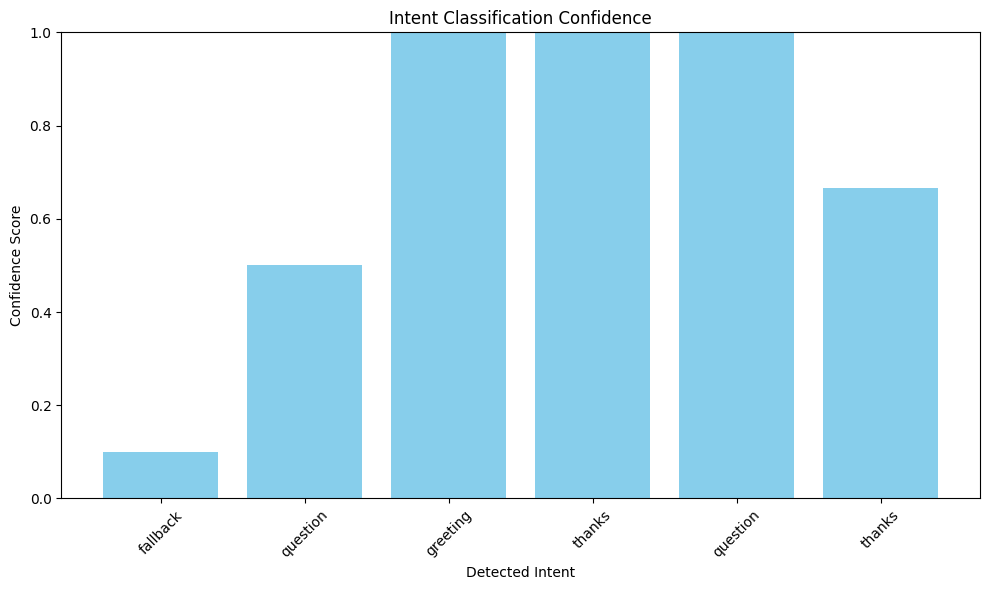

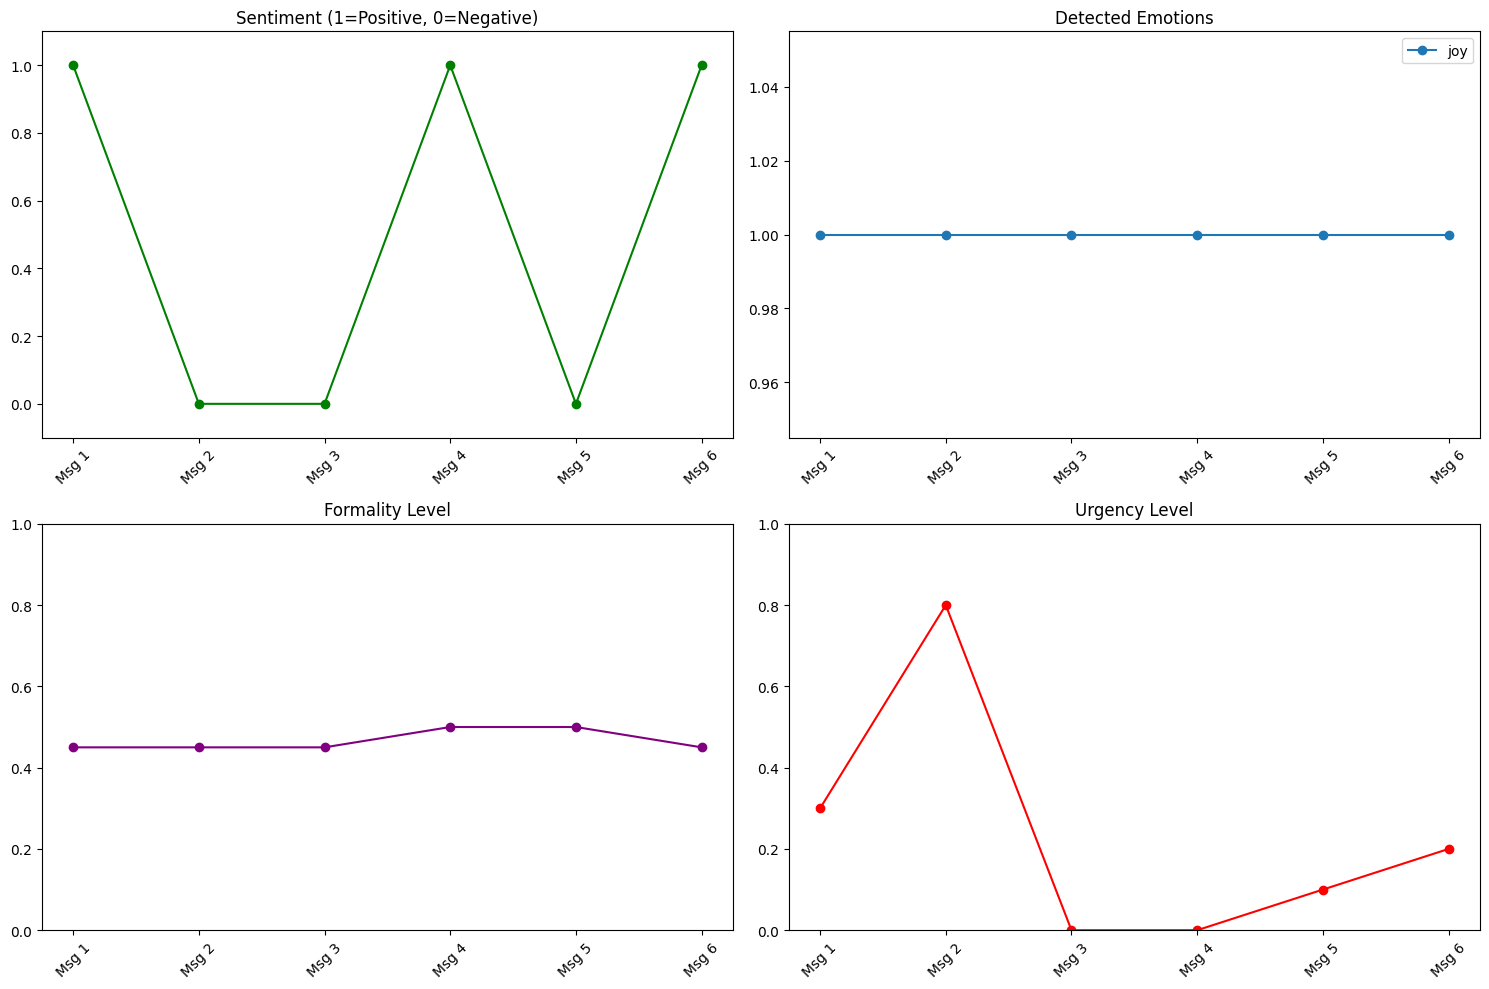


Demo complete!


In [21]:
def main():
    print("Initializing the Conversation Analysis System...")
    system = ConversationSystem()

    print("\nRunning demonstration with sample conversation...")
    demo_messages = [
        "Hi there! Can you help me with something?",
        "I need to know how to reset my password ASAP!",
        "This is really frustrating, I've been locked out for hours.",
        "Thank you for your help, I appreciate it.",
        "By the way, what other security features should I be using?",
        "Ok, thanks again for all your help. Have a good day!"
    ]

    results = system.demo_conversation(demo_messages)

    print("\nGenerating visualizations...")
    plot_intent_confidence(results)
    plot_tone_analysis(results)

    print("\nDemo complete!")

# Run the main demo if this notebook is executed
if __name__ == "__main__":
    main()